### Hedging with Real SPX Option Data

We implement and evaluate delta hedging strategeis for SPX index European call options using real market data. Create a standardized set of calibration and hedging metrics so that results that are comparable.

#### Dataset

The dataset consists of SPX call option quotes (WRDS export) over the period 2023-02-01 to 2023-02-28. For each trading date $t$ and each option contract (strike $K$, expiry $T$), the dataset contains at least

```
(date, exdate, symbol, strike price, best bid, best offer, impl volatility, delta, cp flag)
```

Use ```cp_flag = 'C'``` (calls only).

*NOTE:* Let $S_t$ denote the SPX close on date $t$. If $S_t$ is not included in the WRDS export, we must source it externally and merge it by date. 

Let $t$ index trading days. For any end-of-day quantity $X_t$ define

$$\Delta X_t := X_{t+1} - X_t$$

**Midquote:** Define the call option midquote by $V_t$ by:

$$V_t := \frac{\text{bid}_t + \text{ask}_t}{2} \quad \text{(use best bid/offer if available).}$$

**Maturity:** Define the days-to-expiration and year fraction:

$$D_t := (T - t) \text{ in days}, \quad \tau_t := \frac{D_t}{365}.$$

**Underlying:** Let $S_t$ denote the SPX close, with one-day change $$\Delta S_t := S_{t+1} - S_t$$

**Delta-hedge residual:** Given a delta hedge process $\delta t$ define the hedging residual:

$$\varepsilon_t(\delta) := \Delta V_t - \delta_t \Delta S_t.$$

**SSE and Gain:** For a set of observations $\mathcal{I}$, define:

$$\text{SSE}_{\mathcal{I}}(\delta) := \sum_{t \in \mathcal{I}} \varepsilon_t(\delta)^2.$$

Given two delta hedges, define the Gain:

$$\text{Gain}(A \text{ vs } B) := 1 - \frac{\text{SSE}(\delta^{(A)})}{\text{SSE}(\delta^{(B)})}$$

where both SSEs are computed over the same observation set.

*NOTE*: The competitive score will be based on SSE and Gain computed after the filtering and bucketing (Step 6).

#### Step 1: Data loading and cleaning

Load the option panel and apply the following preprocessing

- Keep calls only
- Convert dates to consistent format
- Rescale striks if needed to sthat strikes are in index-point units
- Construct the midquote $V_t$
- Remove observations with missing or invalid implied volatility

In [48]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Load raw data
raw = pd.read_csv("data/option20230201_20230228.csv")
print(f"Raw rows: {len(raw)}")

# Filter to calls only
df = raw[raw["cp_flag"] == "C"].copy()
print(f"Rows after filtering to calls: {len(df)}")

# Convert dates
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# Rescale strikes (WRDS stores strike × 1000)
df["strike_price"] = df["strike_price"] / 1000

# Construct midquote
df["Vt"] = (df["best_bid"] + df["best_offer"]) / 2

# Remove zero-midquote rows (bid=0 and ask=0)
before_zero = len(df)
df = df[df["Vt"] > 0]
print(f"Dropped {before_zero - len(df)} zero-midquote rows, remaining: {len(df)}")

# Remove missing/invalid implied volatility
before_iv = len(df)
df = df[df["impl_volatility"].notna() & (df["impl_volatility"] > 0)]
print(f"Dropped {before_iv - len(df)} missing/invalid IV rows, remaining: {len(df)}")

Raw rows: 175301
Rows after filtering to calls: 175301
Dropped 0 zero-midquote rows, remaining: 175301
Dropped 21573 missing/invalid IV rows, remaining: 153728


**Required Reporting:**

- Row counts before/after filtering to calls
- Number of unique trading dates and unique expiries
- Missing rates of ($V_t$, $\sigma_{mkt}$, $\delta$)
- The list of final columns kept for the project

In [49]:
# Required Reporting 

# Row counts before/after filtering
print("=" * 50)
print("Row Counts")
print(f"  Raw dataset:              {len(raw)}")
print(f"  After calls filter:       {len(raw[raw['cp_flag'] == 'C'])}")
print(f"  After zero-midquote drop: {before_zero - (before_zero - len(df) + (before_iv - len(df)))}")  
print(f"  After IV filter (final):  {len(df)}")

# Unique trading dates and expiries
print("\n" + "=" * 50)
print("Dates")
print(f"  Unique trading dates: {df['date'].nunique()}")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  Unique expiries:      {df['exdate'].nunique()}")

# Missing rates for key columns
print("\n" + "=" * 50)
print("Missing Rates (after cleaning)")
for col in ["Vt", "impl_volatility", "delta"]:
    miss = df[col].isna().sum()
    print(f"  {col:20s}: {miss}/{len(df)} ({100*miss/len(df):.2f}%)")

# Final columns to keep
keep_cols = [
    "date", "exdate", "symbol", "strike_price",
    "best_bid", "best_offer", "Vt",
    "impl_volatility", "delta", "cp_flag"
]
df = df[keep_cols]

print("\n" + "=" * 50)
print("Final Columns")
print(f"  {keep_cols}")
print(f"  Final shape: {df.shape}")

Row Counts
  Raw dataset:              175301
  After calls filter:       175301
  After zero-midquote drop: 132155
  After IV filter (final):  153728

Dates
  Unique trading dates: 19
  Date range: 2023-02-01 to 2023-02-28
  Unique expiries:      67

Missing Rates (after cleaning)
  Vt                  : 0/153728 (0.00%)
  impl_volatility     : 0/153728 (0.00%)
  delta               : 0/153728 (0.00%)

Final Columns
  ['date', 'exdate', 'symbol', 'strike_price', 'best_bid', 'best_offer', 'Vt', 'impl_volatility', 'delta', 'cp_flag']
  Final shape: (153728, 10)


#### Step 2: Constract time seriesa nd one-day option changes

Construct a contract identifier that tracks the same option over time (e.g. using ```symbol```). Within each contract, compute one-day changes

$$
\Delta V_t = V_{t+1} - V_t
$$

and keep only observations for which $\Delta V_t$ is defined.

In [ ]:
df = df.sort_values(["symbol", "date"])
df["delta_Vt"] = df.groupby("symbol")["Vt"].diff(-1) * (-1)

trading_dates = sorted(df["date"].unique())
date_rank = {d: i for i, d in enumerate(trading_dates)}

df["date_rank"] = df["date"].map(date_rank)
df["next_date_rank"] = df.groupby("symbol")["date_rank"].shift(-1)  

df.loc[df["next_date_rank"] != df["date_rank"] + 1, "delta_Vt"] = np.nan  

df = df.drop(columns=["date_rank", "next_date_rank"])

before_delta = len(df)
df_step2 = df[df["delta_Vt"].notna()].copy()
print(f"Rows before Delta_Vt filter: {before_delta}")
print(f"Rows after Delta_Vt filter:  {len(df_step2)}")

Rows before Delta_Vt filter: 153728
Rows after Delta_Vt filter:  135386


**Required Reporting:**
- summary statistics of $V_t$ and and $\Delta V_t$
- number of contracts retained after constructing $\Delta V_t$

In [51]:
# Required Reporting
print("\n" + "-" * 50)
print("Vt")
print(df_step2["Vt"].describe().round(4))

print("\n" + "-" * 50)
print("Delta_Vt")
print(df_step2["delta_Vt"].describe().round(4))

print("\n" + "-" * 50)
n_contracts = df_step2["symbol"].nunique()
print(f"Number of unique contracts retained: {n_contracts}")


--------------------------------------------------
Vt
count    135386.0000
mean        399.3788
std         537.2200
min           0.0250
25%          31.8000
50%         187.1000
75%         559.1875
max        3945.6000
Name: Vt, dtype: float64

--------------------------------------------------
Delta_Vt
count    135386.0000
mean         -5.8744
std          25.7089
min        -119.3000
25%         -20.0500
50%          -2.0250
75%           4.4500
max          70.2000
Name: delta_Vt, dtype: float64

--------------------------------------------------
Number of unique contracts retained: 11004


#### Step 3: Underlying SPX merge and one-day underlying changes

Obtain the SPX close series ${S_t}$ over the full sample and compute:

$$
\Delta S_t = S_{t+1} - S_t
$$

Merge $S_t$ and $\Delta S_t$ into the option panel by date.

In [52]:
# Download SPX close via yfinance 
# end is exclusive in yfinance, so we use 2023-03-03 to include 2023-03-02
spx = yf.download("^GSPC", start="2023-02-01", end="2023-03-03")[["Close"]]
spx.columns = spx.columns.droplevel(1)
spx = spx.rename(columns={"Close": "St"})
spx.index = pd.to_datetime(spx.index)

[*********************100%***********************]  1 of 1 completed


In [53]:
# Compute Delta_St = S(t+1) - S(t)
spx["delta_St"] = spx["St"].shift(-1) - spx["St"]
print(spx.head())

Price                St   delta_St
Date                              
2023-02-01  4119.209961  60.549805
2023-02-02  4179.759766 -43.279785
2023-02-03  4136.479980 -25.399902
2023-02-06  4111.080078  52.919922
2023-02-07  4164.000000 -46.140137


In [54]:
# Merge into option panel by date 
df_step2 = df_step2.merge(spx, left_on="date", right_index=True, how="left")

**Required Reporting:**
- Merge coverage: % of the option observations matched to valid ($S_t, \Delta S_t$)
- Summary statistics of $S_t$ and $\Delta S_t$
- One plot of $S_t$ and one plot of $\Delta S_t$ over time

In [55]:
# Required Reporting
matched = df_step2["St"].notna().sum()
print(f"\nMerge coverage: {matched}/{len(df_step2)} ({100*matched/len(df_step2):.1f}%)")

print("\n" + "=" * 50)
print("St")
print(df_step2["St"].describe().round(2))

print("\n" + "=" * 50)
print("Delta_St")
print(df_step2["delta_St"].describe().round(2))


Merge coverage: 135386/135386 (100.0%)

St
count    135386.00
mean       4084.76
std          65.18
min        3970.04
25%        4012.32
50%        4090.46
75%        4136.48
max        4179.76
Name: St, dtype: float64

Delta_St
count    135386.00
mean         -8.88
std          37.86
min         -81.75
25%         -42.28
50%         -11.32
75%          12.20
max          60.55
Name: delta_St, dtype: float64


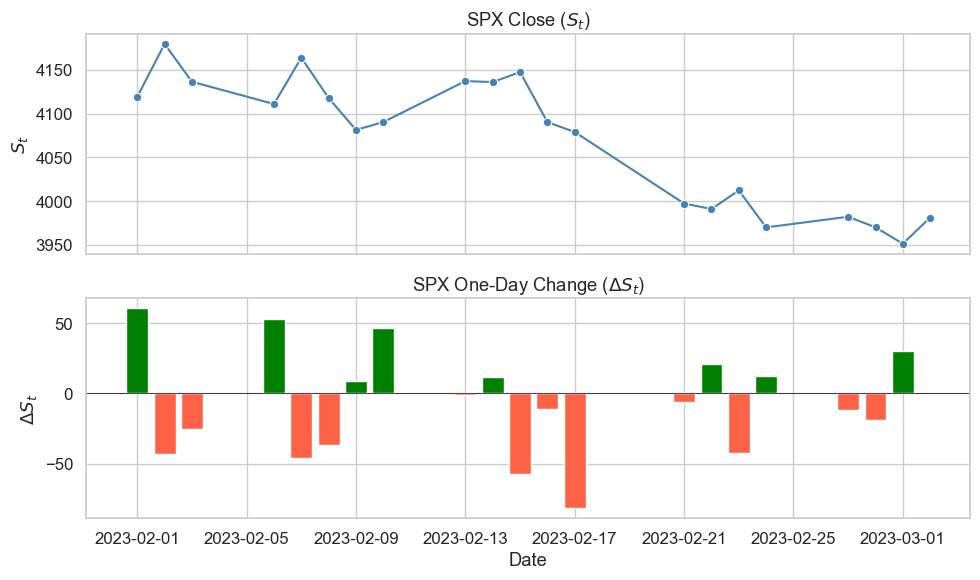

In [56]:
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot St
sns.lineplot(x=spx.index, y=spx["St"], ax=ax1, marker="o", color="steelblue", linewidth=1.5)
ax1.set_title("SPX Close ($S_t$)")
ax1.set_ylabel("$S_t$")

# Plot ΔSt
delta = spx["delta_St"].dropna()
colors = ["green" if v >= 0 else "tomato" for v in delta]
ax2.bar(delta.index, delta.values, color=colors, width=0.8)
ax2.axhline(0, color="black", linewidth=0.5)
ax2.set_title("SPX One-Day Change ($\\Delta S_t$)")
ax2.set_ylabel("$\\Delta S_t$")
ax2.set_xlabel("Date")

fig.tight_layout()
plt.show()

#### Step 4: Stripping a daily risk-free curve with NSS model and extracting $r_t(\tau)$

For every trading date $t$, construct a smooth risk-free zero-rate curve and then evaluate it at each option maturity $\tau$ in your panel. The output is a continuously compounded zero rate $r_t(\tau)$ that will be used consistenlty in

- discounting: $e^{-r_t(\tau) \tau}$
- forward mapping: $F_t(\tau) = S_t e^{(r_t(\tau) - q) \tau}$



**Data Source US Treasury par yields):**

Let $y_t(m)$ denote the observed US Treasury par yield on date $t$ for a given standard maturity $m$. We use the Daily Treasure Par Yield Curve archive.

In practice, yields are provided in annualized % units and must be converted to decimals.

In [57]:
import pandas as pd

url = (
    "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/"
    "daily-treasury-rate-archives/par-yield-curve-rates-2020-2023.csv"
)

treasury = pd.read_csv(url)
treasury["date"] = pd.to_datetime(treasury["date"]).dt.normalize()

In [58]:
print("Columns:", treasury.columns.tolist())
print("Shape:", treasury.shape)
print(treasury.head())

Columns: ['date', '1 mo', '2 mo', '3 mo', '4 mo', '6 mo', '1 yr', '2 yr', '3 yr', '5 yr', '7 yr', '10 yr', '20 yr', '30 yr']
Shape: (1001, 14)
        date  1 mo  2 mo  3 mo  4 mo  6 mo  1 yr  2 yr  3 yr  5 yr  7 yr  \
0 2020-01-02  1.53  1.55  1.54   NaN  1.57  1.56  1.58  1.59  1.67  1.79   
1 2020-01-03  1.52  1.55  1.52   NaN  1.55  1.55  1.53  1.54  1.59  1.71   
2 2020-01-06  1.54  1.54  1.56   NaN  1.56  1.54  1.54  1.56  1.61  1.72   
3 2020-01-07  1.52  1.53  1.54   NaN  1.56  1.53  1.54  1.55  1.62  1.74   
4 2020-01-08  1.50  1.53  1.54   NaN  1.56  1.55  1.58  1.61  1.67  1.78   

   10 yr  20 yr  30 yr  
0   1.88   2.19   2.33  
1   1.80   2.11   2.26  
2   1.81   2.13   2.28  
3   1.83   2.16   2.31  
4   1.87   2.21   2.35  


**Objective:** For each option observation $(t, K, T)$ with year-fraction maturity $\tau = (T - t)/365$, we want to attach a risk-free rate $r_t(\tau)$.

To obtain the risk-free rate we do the following:

- align the Treasury curve to fit the option trading curves
- fit an NSS parametric yield curve for each date
- evaluate the fitted curve at option maturity $\tau$
- convert the resulting annual yield quote into a continuously compounding zero rate.

#### (a) Data alignment and missing-day handling

Let $\mathcal{T}^{\text{opt}}$ be the set of option trading dates in the panel. Construct a treasury yield panel indexied by  $\mathcal{T}^{\text{opt}}$ by forward-filling missing treasury observations:

$$
y_t(m) \leftarrow y_{\max \{s \leq t: s \in \mathcal{T}^{\text{tr}}\}}(m), \quad t \in \mathcal{T}^{\text{opt}},
$$

where $\mathcal{T}^{\text{tr}}$ the dates available in the Treasury file. This ensures that every option date has a full set of yields.

In [59]:
tenor_map = {
    "1 mo": 1/12,
    "2 mo": 2/12,
    "3 mo": 3/12,
    "4 mo": 4/12,
    "6 mo": 6/12,
    "1 yr": 1,
    "2 yr": 2,
    "3 yr": 3,
    "5 yr": 5,
    "7 yr": 7,
    "10 yr": 10,
    "20 yr": 20,
    "30 yr": 30,
}

# Convert yields from % to decimals 
yield_cols = list(tenor_map.keys())
treasury[yield_cols] = treasury[yield_cols] / 100

# Filter treasury to cover option dates (with some buffer before)
treasury = treasury[treasury["date"] >= "2023-01-15"].copy()
treasury = treasury.sort_values("date").set_index("date")

# Get option trading dates
option_dates = sorted(df_step2["date"].unique())
print(f"Option trading dates: {len(option_dates)}")
print(f"First: {option_dates[0].date()}, Last: {option_dates[-1].date()}")

# Reindex treasury to option dates, forward-filling gaps
all_dates = treasury.index.union(option_dates)
treasury = treasury.reindex(all_dates).ffill()

# Keep only option trading dates
treasury_aligned = treasury.loc[option_dates].copy()

print(f"\nAligned treasury shape: {treasury_aligned.shape}")
print(f"NaN count per tenor:\n{treasury_aligned[yield_cols].isna().sum()}")
print(f"\nSample (first 3 dates):")
print(treasury_aligned.head(3).round(5))

Option trading dates: 18
First: 2023-02-01, Last: 2023-02-27

Aligned treasury shape: (18, 13)
NaN count per tenor:
1 mo     0
2 mo     0
3 mo     0
4 mo     0
6 mo     0
1 yr     0
2 yr     0
3 yr     0
5 yr     0
7 yr     0
10 yr    0
20 yr    0
30 yr    0
dtype: int64

Sample (first 3 dates):
              1 mo    2 mo    3 mo    4 mo    6 mo    1 yr    2 yr    3 yr  \
date                                                                         
2023-02-01  0.0459  0.0463  0.0466  0.0477  0.0479  0.0466  0.0409  0.0375   
2023-02-02  0.0462  0.0465  0.0466  0.0475  0.0476  0.0464  0.0409  0.0375   
2023-02-03  0.0461  0.0467  0.0470  0.0480  0.0482  0.0479  0.0430  0.0396   

              5 yr    7 yr   10 yr   20 yr   30 yr  
date                                                
2023-02-01  0.0348  0.0343  0.0339  0.0367  0.0355  
2023-02-02  0.0349  0.0344  0.0340  0.0367  0.0355  
2023-02-03  0.0367  0.0361  0.0353  0.0377  0.0363  


#### (b) NSS curve

For each date $t$, fit a smooth parametric function $y_t(\tau)$ defined for any maturity $\tau > 0$:

$$
y_t(\tau) = \beta_{0,t} + \beta_{1,t} g_1(\tau; \tau_{1,t}) + \beta_{2,t} g_2(\tau; \tau_{1,t}) + \beta_{3,t} g_3(\tau; \tau_{2,t})
$$

where the basis functions are

$$
g_1(\tau; \lambda) = \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda}, 

g_2(\tau; \lambda) = g_1(\tau; \lambda) - e^{-\tau/\lambda}, 

g_3(\tau; \lambda) = \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda}
$$

In [60]:
# Tenors in years (the observed maturities)
tenors = np.array([tenor_map[c] for c in yield_cols])

# NSS basis functions
def g1(tau, lam):
    x = tau / lam
    return (1 - np.exp(-x)) / x

def g2(tau, lam):
    return g1(tau, lam) - np.exp(-tau / lam)

def g3(tau, lam):
    return g1(tau, lam) - np.exp(-tau / lam)

# Full NSS yield curve
def nss_yield(tau, beta, tau1, tau2):
    """
    y(tau) = beta0 + beta1 * g1(tau; tau1) + beta2 * g2(tau; tau1) + beta3 * g3(tau; tau2)
    """
    return beta[0] + beta[1] * g1(tau, tau1) + beta[2] * g2(tau, tau1) + beta[3] * g3(tau, tau2)


#### (c) Daily calibration via grid search + conditional OLS

On each date $t$, we observe a discrete set of par yields
\begin{equation*}
    \{(m_j, y_t(m_j))\}_{j=1}^J, \quad J \approx 12.
\end{equation*}

For fixed $(\tau_1, \tau_2)$ the NSS model is \textbf{linear} in the $\beta$ coefficients. Define the regressor matrix
$$
    X(\tau_1, \tau_2) = \begin{pmatrix} 
    1 & g_1(m_1; \tau_1) & g_2(m_1; \tau_1) & g_3(m_1; \tau_2) \\ 
    \vdots & \vdots & \vdots & \vdots \\ 
    1 & g_1(m_J; \tau_1) & g_2(m_J; \tau_1) & g_3(m_J; \tau_2) 
    \end{pmatrix}, \quad 
    \mathbf{y}_t = \begin{pmatrix} 
    y_t(m_1) \\ 
    \vdots \\ 
    y_t(m_J) 
    \end{pmatrix}.
$$

Then the OLS estimate at $(\tau_1, \tau_2)$ is
$$
    \widehat{\beta}_t(\tau_1, \tau_2) = \arg \min_{\beta \in \mathbb{R}^4} \|\mathbf{y}_t - X(\tau_1, \tau_2)\beta\|_2^2 = (X^\top X)^{-1} X^\top \mathbf{y}_t.
$$

We select $(\tau_{1,t}, \tau_{2,t})$ by a grid search:
$$
    (\widehat{\tau}_{1,t}, \widehat{\tau}_{2,t}) = \arg \min_{(\tau_1, \tau_2) \in \mathcal{G}} \text{SSE}_t(\tau_1, \tau_2), \quad \text{SSE}_t(\tau_1, \tau_2) := \|\mathbf{y}_t - X(\tau_1, \tau_2)\widehat{\beta}_t(\tau_1, \tau_2)\|_2^2,
$$
with the constraint $\tau_2 \geq \tau_1$ for numerical stability. Finally, define the fitted daily curve
$$
    \widehat{y}_t(\tau) = y_t(\tau; \widehat{\beta}_t, \widehat{\tau}_{1,t}, \widehat{\tau}_{2,t}).
$$

In [61]:
from numpy.linalg import lstsq

# Design matrix for OLS (linear in beta for fixed tau1, tau2)
def nss_design_matrix(tenors, tau1, tau2):
    X = np.column_stack([
        np.ones_like(tenors),
        g1(tenors, tau1),
        g2(tenors, tau1),
        g3(tenors, tau2),
    ])
    return X


def fit_nss(yields, tenors, tau1_grid, tau2_grid):
    best_sse = np.inf
    best_params = None
    
    for tau1 in tau1_grid:
        for tau2 in tau2_grid:
            if tau2 < tau1:
                continue
            X = nss_design_matrix(tenors, tau1, tau2)
            beta, _, _, _ = lstsq(X, yields, rcond=None)
            sse = np.sum((yields - X @ beta) ** 2)
            if sse < best_sse:
                best_sse = sse
                best_params = {"beta": beta, "tau1": tau1, "tau2": tau2, "sse": sse}
    
    return best_params

# Define grid
tau1_grid = np.arange(0.1, 5.1, 0.1)
tau2_grid = np.arange(0.1, 5.1, 0.1)

# Fit NSS for each trading date 
nss_results = {}
for date, row in treasury_aligned.iterrows():
    yields = row[yield_cols].values.astype(float)
    mask = ~np.isnan(yields)
    nss_results[date] = fit_nss(yields[mask], tenors[mask], tau1_grid, tau2_grid)

print(f"Fitted NSS for {len(nss_results)} dates")
for date in list(nss_results.keys())[:3]:
    r = nss_results[date]
    print(f"{date.date()}: tau1={r['tau1']:.1f}, tau2={r['tau2']:.1f}, SSE={r['sse']:.2e}, beta={np.round(r['beta'], 5)}")


Fitted NSS for 18 dates
2023-02-01: tau1=0.6, tau2=2.0, SSE=2.43e-06, beta=[ 0.03704  0.0073   0.03539 -0.02645]
2023-02-02: tau1=0.7, tau2=1.8, SSE=2.33e-06, beta=[ 0.03694  0.00812  0.0373  -0.03131]
2023-02-03: tau1=0.7, tau2=1.9, SSE=2.40e-06, beta=[ 0.03755  0.00724  0.03749 -0.02577]


#### (d) Evaluting the curve at option maturities

For each option row with maturity $\tau$, compute the annualized fitted yield \widehat{y}_t(\tau). To avoid ill-defined $\tau = 0$ limit in the basis functions and in discounting, apply a lower bound: 

$$
\tau \leftarrow \max\{\tau, 1/365\}.
$$

In [62]:
# Compute maturity τ for each option observation
df_step2["tau"] = (df_step2["exdate"] - df_step2["date"]).dt.days / 365

# Apply lower bound
df_step2["tau"] = df_step2["tau"].clip(lower=1/365)

# Evaluate NSS fitted yield at each option's maturity
def get_nss_yield(row, nss_results):
    r = nss_results[row["date"]]
    tau = np.array([row["tau"]])
    return nss_yield(tau, r["beta"], r["tau1"], r["tau2"])[0]

df_step2["y_fitted"] = df_step2.apply(get_nss_yield, axis=1, nss_results=nss_results)

print(f"Fitted yield (y) summary:")
print(df_step2["y_fitted"].describe().round(6))

Fitted yield (y) summary:
count    135386.000000
mean          0.047355
std           0.001969
min           0.034691
25%           0.046006
50%           0.047298
75%           0.048772
max           0.051517
Name: y_fitted, dtype: float64


#### (e) Converting treasury yeild quotes to a continuously-compounded zero rate.

Treasury par yields are quoted using semiannual compounding. Therefore continuously zero rate is defined by:

$$
r_t(\tau) = 2 \ln \left( 1 + \frac{\widehat{y}_t(\tau)}{2} \right)
$$

**Discount factor and forward:** Once $r_t(\tau)$ is available for each option observation:

$$
P_t(\tau) = e^{-r_t(\tau)\tau}, \qquad F_t(\tau) = S_t e^{(r_t(\tau)-q)\tau},
$$

where in this lab we set $q = 0$.

In [63]:
def to_continuous_rate(y):
    return 2 * np.log(1 + y / 2)

df_step2["rt"] = 2 * np.log(1 + df_step2["y_fitted"] / 2)

# Calculate discount factor P(t) and forward price F(t)
df_step2["Pt"] = np.exp(-df_step2["rt"] * df_step2["tau"])
df_step2["Ft"] = df_step2["St"] * np.exp(df_step2["rt"] * df_step2["tau"])

**Required Reporting:**

- a table/summary of ${r_t(\tau)}$ values (min/median/max) across the option panel
- one plot of the fitted curve $\tau \rightarrow r_t(\tau)$ for a representative date
- verification that every option has a finite $r_t(\tau)$ and discount factor $P_t(\tau)$

In [64]:
# 1. Summary of rt values
print("Summary of r_t")
print(f"  Min:    {df_step2['rt'].min():.6f}")
print(f"  Median: {df_step2['rt'].median():.6f}")
print(f"  Max:    {df_step2['rt'].max():.6f}")
print(f"  Mean:   {df_step2['rt'].mean():.6f}")
print(f"  Std:    {df_step2['rt'].std():.6f}")

# Verification: every row has finite rt and Pt
rt_finite = np.isfinite(df_step2["rt"]).all()
pt_finite = np.isfinite(df_step2["Pt"]).all()
print("\n" + "-" * 50)
print("Verification")
print(f"  All r_t finite:  {rt_finite}")
print(f"  All P_t finite:  {pt_finite}")
print(f"  Any rt NaN:        {df_step2['rt'].isna().sum()}")
print(f"  Any Pt NaN:        {df_step2['Pt'].isna().sum()}")

Summary of r_t
  Min:    0.034393
  Median: 0.046747
  Max:    0.050865
  Mean:   0.046802
  Std:    0.001924

--------------------------------------------------
Verification
  All r_t finite:  True
  All P_t finite:  True
  Any rt NaN:        0
  Any Pt NaN:        0


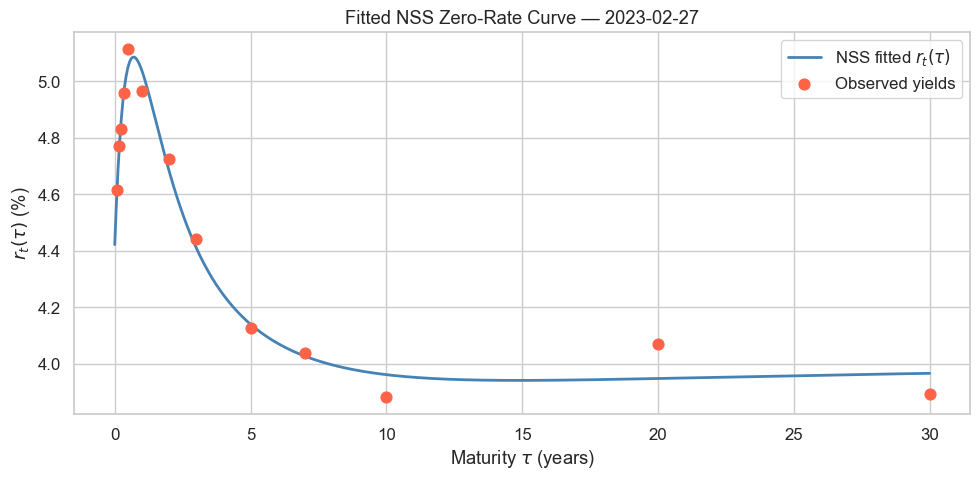

In [65]:
# Plot fitted curve for a representative date
rep_date = pd.Timestamp("2023-02-28")
if rep_date not in nss_results:
    rep_date = max(d for d in nss_results.keys() if d <= rep_date)
    
sns.set_theme(style="whitegrid", font_scale=1.1)
    
r = nss_results[rep_date]
tau_plot = np.linspace(1/365, 30, 500)
y_plot = nss_yield(tau_plot, r["beta"], r["tau1"], r["tau2"])
r_plot = 2 * np.log(1 + y_plot / 2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tau_plot, r_plot * 100, color="steelblue", linewidth=2, label="NSS fitted $r_t(\\tau)$")

# Overlay observed par yields (converted)
obs_yields = treasury_aligned.loc[rep_date, yield_cols].values.astype(float)
obs_r = 2 * np.log(1 + obs_yields / 2)
ax.scatter(tenors, obs_r * 100, color="tomato", zorder=5, s=60, label="Observed yields")

ax.set_xlabel("Maturity $\\tau$ (years)")
ax.set_ylabel("$r_t(\\tau)$ (%)")
ax.set_title(f"Fitted NSS Zero-Rate Curve — {rep_date.date()}")
ax.legend()
fig.tight_layout()
plt.show()

#### Step 5: BS delta hedging and hedging performance

This step establishes the baseline hedge performance.

**(a) Baseline delta:** If a dataset-provided hedge delta is available, use it as a baseline

$$
\Delta_t^{\text{BS}} := \delta_t^{\text{vendor}}
$$

In [66]:
# Baseline delta
df_step2["delta_BS"] = df_step2["delta"]
# Compute days to expiry (needed for the filter)
df_step2["Dt"] = (df_step2["exdate"] - df_step2["date"]).dt.days

print("Baseline delta (vendor) summary:")
print(df_step2["delta_BS"].describe().round(4))
print(f"\nDays to expiry (Dt) range: {df_step2['Dt'].min()} to {df_step2['Dt'].max()}")
print(f"Rows entering Step 5: {len(df_step2)}")

Baseline delta (vendor) summary:
count    135386.0000
mean          0.5659
std           0.3470
min           0.0001
25%           0.2406
50%           0.6588
75%           0.8870
max           0.9997
Name: delta_BS, dtype: float64

Days to expiry (Dt) range: 2 to 1780
Rows entering Step 5: 135386


**(b) Baseline residuals and SSE:** Compute residuals

$$
    \varepsilon_t(\Delta^{\text{BS}}) = \Delta V_t - \Delta_t^{\text{BS}} \Delta S_t,
$$

and the corresponding sum of squared erros (SSE) is:

$$
\text{SSE}(\Delta^{\text{BS}}) = \sum_{t} \varepsilon_t(\Delta^{\text{BS}})^2.
$$

In [67]:
# Baseline residuals and SSE (before filters)
df_step2["epsilon_BS"] = df_step2["delta_Vt"] - df_step2["delta_BS"] * df_step2["delta_St"]
print("Hedging residual ε_t(Δ^BS) — BEFORE filters:")
print(df_step2["epsilon_BS"].describe().round(4))
print(f"\nSSE (pre-filter): {(df_step2['epsilon_BS']**2).sum():.4f}")

Hedging residual ε_t(Δ^BS) — BEFORE filters:
count    135386.0000
mean         -0.3030
std           3.2397
min         -83.6186
25%          -2.5761
50%          -0.0750
75%           1.6424
max          98.4682
Name: epsilon_BS, dtype: float64

SSE (pre-filter): 1433392.4451


**(c) Standardized filters**: After computing deltas, filter out observations observations with:

$$
\Delta_t^{\text{BS}} \leq 0.05, \quad \Delta_t^{\text{BS}} \geq 0.95, \quad D_t \leq 14.
$$

Filtering out options with extreme delta values and maturity less than 14 days will help with the analysis of the results. Report the remaining row count after each filter.

In [68]:
# Filters 

n_before = len(df_step2)

mask_delta_low  = df_step2["delta_BS"] <= 0.05
mask_delta_high = df_step2["delta_BS"] >= 0.95
mask_maturity   = df_step2["Dt"] <= 14

print(f"Rows before filters:          {n_before}")
print(f"  Dropped by Delta  <= 0.05:   {mask_delta_low.sum()}")
print(f"  Dropped by D >= 0.95:        {mask_delta_high.sum()}")
print(f"  Dropped by D_t <= 14:        {mask_maturity.sum()}")

# Also drop any rows with NaN in the residual
mask_nan = df_step2["epsilon_BS"].isna()
print(f"  Dropped by NaN residual:     {mask_nan.sum()}")

# Apply all filters
mask_keep = ~mask_delta_low & ~mask_delta_high & ~mask_maturity & ~mask_nan
df_filtered = df_step2[mask_keep].copy()

print(f"\nRows after all filters:        {len(df_filtered)}")

Rows before filters:          135386
  Dropped by Delta  <= 0.05:   19819
  Dropped by D >= 0.95:        17202
  Dropped by D_t <= 14:        17672
  Dropped by NaN residual:     0

Rows after all filters:        87835


In [69]:
# Baseline SSE and MSE on filtered sample
SSE_BS = (df_filtered["epsilon_BS"] ** 2).sum()
MSE_BS = (df_filtered["epsilon_BS"] ** 2).mean()
N_obs  = len(df_filtered)

print(f"\n{'='*50}")
print(f"Baseline Performance(filtered)")
print(f"  N observations:  {N_obs}")
print(f"  SSE(D^BS):       {SSE_BS:.4f}")
print(f"  MSE(D^BS):       {MSE_BS:.6f}")
print(f"  RMSE(D^BS):      {np.sqrt(MSE_BS):.6f}")

print(f"\nResidual summary (filtered):")
print(df_filtered["epsilon_BS"].describe().round(6))


Baseline Performance(filtered)
  N observations:  87835
  SSE(D^BS):       994700.6511
  MSE(D^BS):       11.324650
  RMSE(D^BS):      3.365212

Residual summary (filtered):
count    87835.000000
mean        -0.362216
std          3.345680
min        -83.618586
25%         -3.011125
50%         -0.402172
75%          2.000744
max         98.468194
Name: epsilon_BS, dtype: float64


**(d) Standardized bucketing:** Create
- 9 moneyness buckets based on $\Delta_t^{\text{BS}}$ using equal-width bins over $(0.05, 0.95)$
- 7 maturity buckets based on $D_t$ using equal-width bins ober the filtered maturity range.

In [70]:
# Standardized bucketing

delta_bins = np.linspace(0.05, 0.95, 10)  # 9 bins
Dt_min, Dt_max = df_filtered["Dt"].min(), df_filtered["Dt"].max()
maturity_bins = np.linspace(Dt_min, Dt_max, 8)  # 7 bins

df_filtered["delta_bucket"] = pd.cut(
    df_filtered["delta_BS"], bins=delta_bins, include_lowest=True
)
df_filtered["maturity_bucket"] = pd.cut(
    df_filtered["Dt"], bins=maturity_bins, include_lowest=True
)

n_before_bucket = len(df_filtered)
df_filtered = df_filtered.dropna(subset=["delta_bucket", "maturity_bucket"])
print(f"Rows lost to bucketing edge cases: {n_before_bucket - len(df_filtered)}")
print(f"Final bucketed sample: {len(df_filtered)}")

Rows lost to bucketing edge cases: 0
Final bucketed sample: 87835


**(e) Hedging residuals and SSEs:** Compute the residuals

$$\varepsilon_t(\Delta_t^{\text{BS}}) := \Delta V_t - \Delta_t^{\text{BS}} \Delta S_t$$

and compute the total SSEs and MSE on the final filtered sample:

$$
\Delta_t^{\text{BS}} \leq 0.05, \quad \Delta_t^{\text{BS}} \geq 0.95, \quad D_t \leq 14.
$$

In [71]:
#  Compute SSE and MSE per bucket
def bucket_stats(group):
    eps = group["epsilon_BS"]
    return pd.Series({"SSE": (eps**2).sum(), "MSE": (eps**2).mean(), "N": len(eps)})

bucket_results = (
    df_filtered
    .groupby(["delta_bucket", "maturity_bucket"], observed=False)
    .apply(bucket_stats)
    .reset_index()
)

print(f"\nBucket grid: {bucket_results['delta_bucket'].nunique()} × "
      f"{bucket_results['maturity_bucket'].nunique()} = {len(bucket_results)} buckets")
print(f"Empty buckets: {(bucket_results['N'] == 0).sum()}")



Bucket grid: 9 × 7 = 63 buckets
Empty buckets: 9


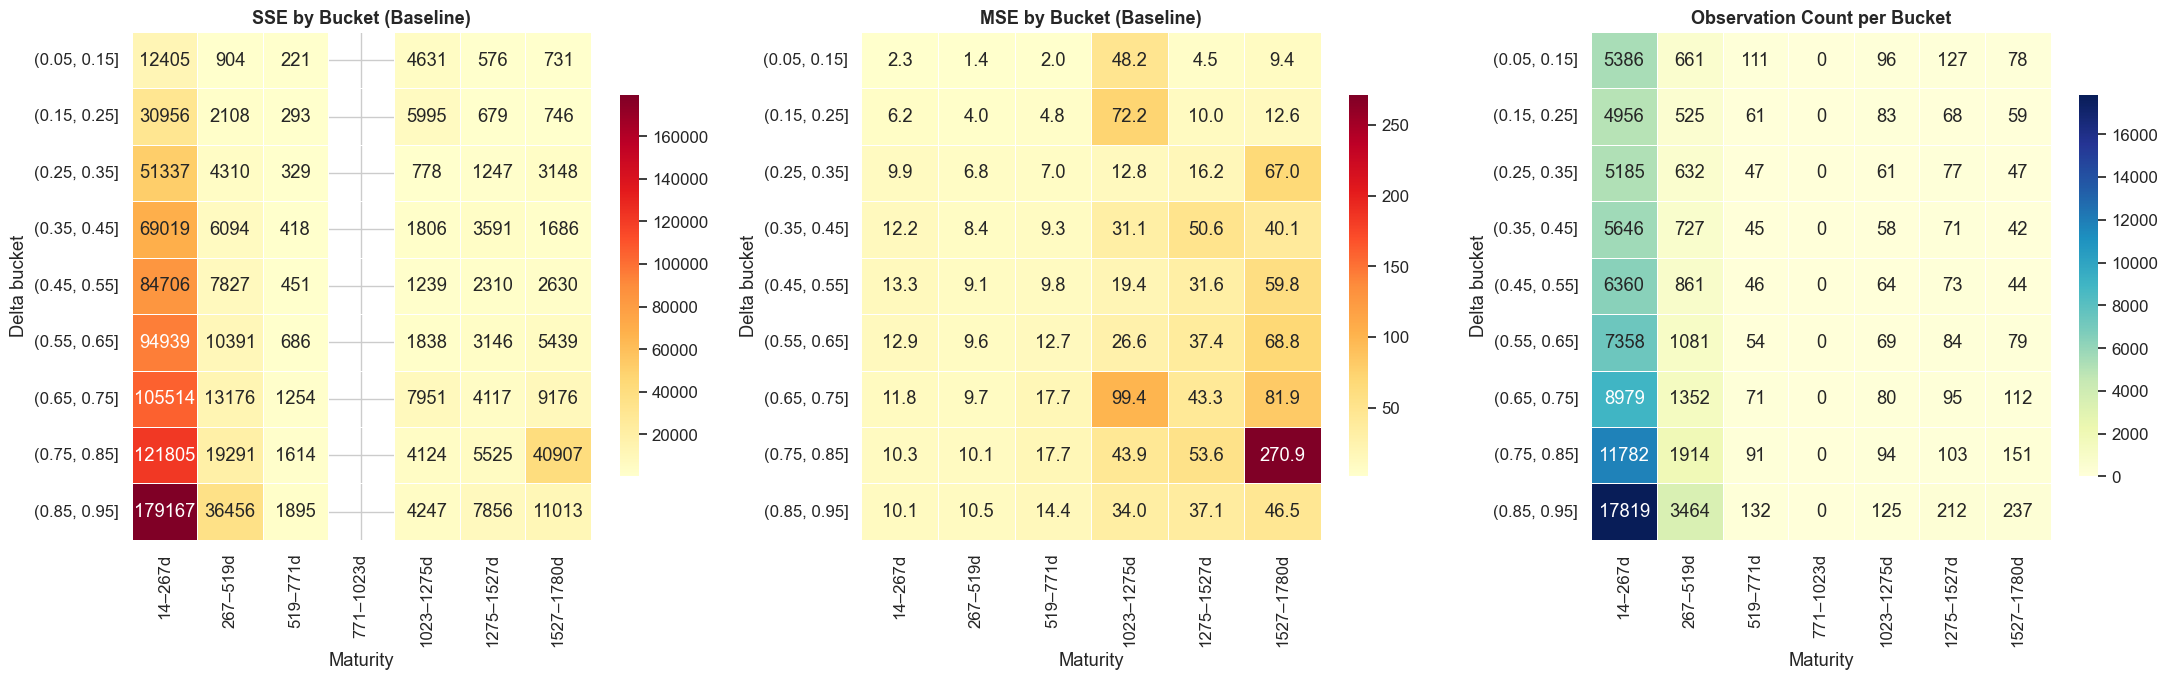


Total SSE (bucketed sample): 994700.6511
Total MSE (bucketed sample): 11.324650
Total N:                     87835


In [72]:
def short_delta_label(interval):
    return f"({interval.left:.2f}, {interval.right:.2f}]"

def short_maturity_label(interval):
    return f"{int(interval.left)}–{int(interval.right)}d"

bucket_results["delta_label"] = bucket_results["delta_bucket"].apply(short_delta_label)
bucket_results["maturity_label"] = bucket_results["maturity_bucket"].apply(short_maturity_label)

# Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

configs = [
    ("SSE",  "SSE by Bucket (Baseline)",       "YlOrRd", ".0f"),
    ("MSE",  "MSE by Bucket (Baseline)",        "YlOrRd", ".1f"),
    ("N",    "Observation Count per Bucket",     "YlGnBu", ".0f"),
]

for ax, (metric, title, cmap, fmt) in zip(axes, configs):
    pivot = bucket_results.pivot_table(
        index="delta_label", columns="maturity_label",
        values=metric, observed=False, sort=False
    )
    # Sort index by delta midpoint (ascending)
    pivot = pivot.sort_index(ascending=True)

    mask = pivot == 0  # mask empty buckets
    sns.heatmap(
        pivot, annot=True, fmt=fmt, cmap=cmap, ax=ax,
        linewidths=0.5, cbar_kws={"shrink": 0.75},
        mask=mask if metric != "N" else None
    )
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xlabel("Maturity")
    ax.set_ylabel("Delta bucket")

plt.tight_layout()
plt.show()

# Print totals
SSE_total = (df_filtered["epsilon_BS"]**2).sum()
MSE_total = (df_filtered["epsilon_BS"]**2).mean()
print(f"\nTotal SSE (bucketed sample): {SSE_total:.4f}")
print(f"Total MSE (bucketed sample): {MSE_total:.6f}")
print(f"Total N:                     {len(df_filtered)}")

Representative date: 2023-02-15
Expiry: 2023-03-17 (D_t = 30 days), 276 options


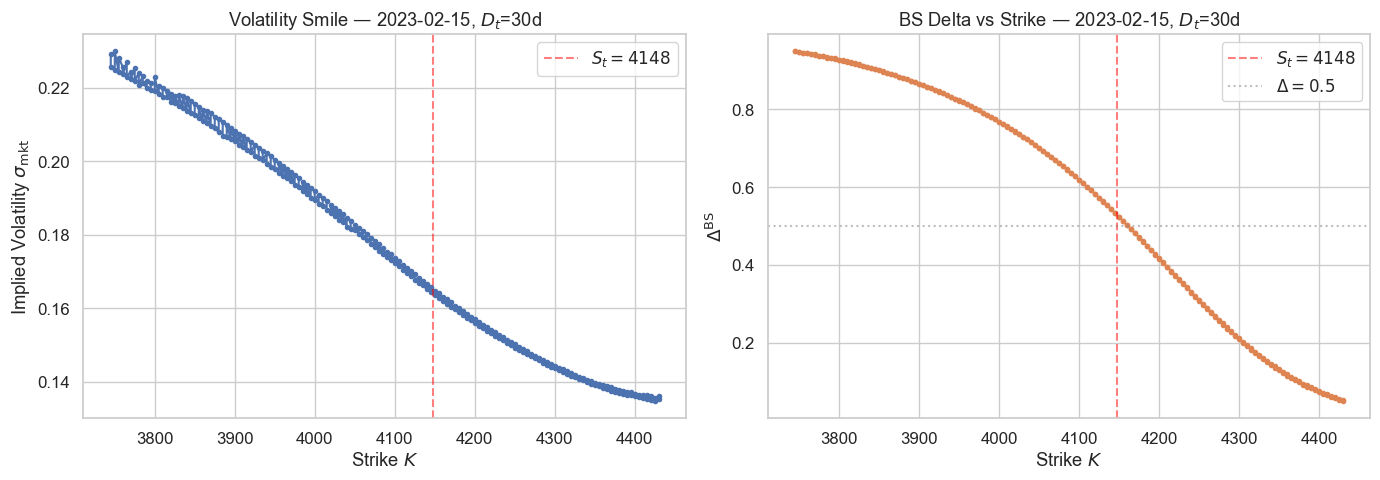

In [73]:
# ── Required plots: Smile + Delta vs Strike ──
rep_date = pd.Timestamp("2023-02-15")
available_dates = sorted(df_filtered["date"].unique())
rep_date = min(available_dates, key=lambda d: abs(d - rep_date))
print(f"Representative date: {rep_date.date()}")

date_slice = df_filtered[df_filtered["date"] == rep_date]
expiries = sorted(date_slice["exdate"].unique())

mid_expiry = None
for ex in expiries:
    dt = (ex - rep_date).days
    if 30 <= dt <= 90:
        mid_expiry = ex
        break
if mid_expiry is None:
    mid_expiry = expiries[len(expiries) // 2]

slice_df = date_slice[date_slice["exdate"] == mid_expiry].sort_values("strike_price")
Dt_slice = (mid_expiry - rep_date).days
spot = slice_df["St"].iloc[0]
print(f"Expiry: {mid_expiry.date()} (D_t = {Dt_slice} days), {len(slice_df)} options")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (i) Smile plot
axes[0].plot(slice_df["strike_price"], slice_df["impl_volatility"], "o-", markersize=3)
axes[0].set_xlabel(r"Strike $K$")
axes[0].set_ylabel(r"Implied Volatility $\sigma_{\mathrm{mkt}}$")
axes[0].set_title(f"Volatility Smile — {rep_date.date()}, $D_t$={Dt_slice}d")
axes[0].axvline(spot, color="red", ls="--", alpha=0.5, label=rf"$S_t={spot:.0f}$")
axes[0].legend()

# (ii) Delta plot
axes[1].plot(slice_df["strike_price"], slice_df["delta_BS"], "o-", markersize=3, color="C1")
axes[1].set_xlabel(r"Strike $K$")
axes[1].set_ylabel(r"$\Delta^{\mathrm{BS}}$")
axes[1].set_title(f"BS Delta vs Strike — {rep_date.date()}, $D_t$={Dt_slice}d")
axes[1].axvline(spot, color="red", ls="--", alpha=0.5, label=rf"$S_t={spot:.0f}$")
axes[1].axhline(0.5, color="gray", ls=":", alpha=0.5, label=r"$\Delta = 0.5$")
axes[1].legend()

plt.tight_layout()
plt.show()

**Required reporting:**
- summary statistics of $\varepsilon_t(\Delta^{\text{BS}})$
- baseline $\text{SSE}(\Delta^{\text{BS}})$ after filters
- Study the misspecification effect on the hedging performance for the implied-volatility parameter. Select a grid of implied volatility parameters and hedge the option with different levels of implied-vol $\Delta_t^{\text{BS}}(\sigma)$. Connect the results to the theoretical result obtained in Exercise 2.


**Required plots:**
- Smile plots: $\sigma_{mkt}(K)$ for one chosen $(t, D)$. 
- Delta plots: $K \rightarrow \Delta_t^{\text{BS}}(K)$ for one chosen $(t, D)$.
- Heatmaps of $\text{SSE}_{i,j}(BS)$ and $\text{MSE}_{i,j}(BS)$ across the bucketing constructed.

In [74]:
# Vol Misspecification Study
from scipy.stats import norm

def bs_delta_call(S, K, r, tau, sigma, q=0):
    """Black-Scholes delta for a European call, q=0."""
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

def compute_sse_for_alpha(alpha, df):
    """Compute SSE when hedging with Δ^BS(α · σ_mkt)."""
    sigma_scaled = alpha * df["impl_volatility"]
    delta_scaled = bs_delta_call(
        df["St"], df["strike_price"], df["rt"], df["tau"], sigma_scaled
    )
    eps = df["delta_Vt"] - delta_scaled * df["delta_St"]
    return (eps**2).sum()

In [75]:
# Use a coarse grid first
alphas_coarse = np.arange(0.5, 1.55, 0.1)
sse_coarse = [compute_sse_for_alpha(a, df_filtered) for a in alphas_coarse]

# Find coarse optimum
idx_min = np.argmin(sse_coarse)
alpha_coarse_best = alphas_coarse[idx_min]
print(f"Coarse grid best: alpha = {alpha_coarse_best:.2f}, SSE = {sse_coarse[idx_min]:.2f}")

Coarse grid best: alpha = 1.00, SSE = 1109089.23


In [76]:
# Fine grid around optimum
alphas_fine = np.arange(
    max(0.5, alpha_coarse_best - 0.15),
    min(1.5, alpha_coarse_best + 0.15) + 0.01,
    0.01
)
sse_fine = [compute_sse_for_alpha(a, df_filtered) for a in alphas_fine]

idx_min_fine = np.argmin(sse_fine)
alpha_star = alphas_fine[idx_min_fine]
sse_star = sse_fine[idx_min_fine]

print(f"Fine grid best:   alpha* = {alpha_star:.2f}, SSE = {sse_star:.2f}")
print(f"Baseline (alpha=1):   SSE = {SSE_BS:.2f}")
print(f"Gain(alpha* vs BS):   {1 - sse_star / SSE_BS:.4f}  ({(1 - sse_star / SSE_BS)*100:.2f}%)")

print(f"\nTheoretical alpha (s_real/s_imp ≈ 14.5/20): 0.73")
print(f"Empirical alpha* for SSE:                    {alpha_star:.2f}")

Fine grid best:   alpha* = 1.00, SSE = 1109089.23
Baseline (alpha=1):   SSE = 994700.65
Gain(alpha* vs BS):   -0.1150  (-11.50%)

Theoretical alpha (s_real/s_imp ≈ 14.5/20): 0.73
Empirical alpha* for SSE:                    1.00


In [77]:
sse_alpha1 = compute_sse_for_alpha(1.0, df_filtered)
print(f"  SSE(alpha=1.0):  {sse_alpha1:.2f}  (recomputed baseline)")
print(f"  SSE(alpha*={alpha_star:.2f}): {sse_star:.2f}")
print(f"  Gain(alpha* vs alpha=1): {1 - sse_star/sse_alpha1:.4f}  ({(1 - sse_star/sse_alpha1)*100:.2f}%)")
print(f"\nVendor delta SSE:  {SSE_BS:.2f}  (lower because OM uses q>0 and own rates)")
print(f"  Gap from vendor: {sse_alpha1 - SSE_BS:.2f} ({(sse_alpha1/SSE_BS - 1)*100:.1f}% higher)")

  SSE(alpha=1.0):  1109089.23  (recomputed baseline)
  SSE(alpha*=1.00): 1109089.23
  Gain(alpha* vs alpha=1): 0.0000  (0.00%)

Vendor delta SSE:  994700.65  (lower because OM uses q>0 and own rates)
  Gap from vendor: 114388.57 (11.5% higher)


#### Hull–White MV Delta

The derivation of the BS PDE begins by assuming the option price is a function of two variables only:

$$V = V(S_t, t)$$

Under this assumption, Itô's Lemma gives the exact change in the option price as:

$$
dV = {\frac{\partial V}{\partial t}\,dt + \frac{\partial V}{\partial S}\,dS} + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}(dS)^2
$$

For the delta-hedge, we set $\Delta_t = \frac{\partial V}{\partial S}$ to eliminate the $dW_t$ term. This makes the portfolio risk-free since: 

$$\Pi_t = -V + \Delta_t S_t$$

This yields the BS PDE:

$$\frac{\partial V}{\partial t} + rS\frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - rV = 0$$

The key point is that risk is eliminated by holding $\Delta = \partial V / \partial S$ shares, because $V$ depends on $S$ alone (aside from deterministic time).

In a more realistic setting, the market prices options using an implied volatility $\sigma_{\text{mkt}}(K, T)$ that is not constant over time. The option price can, thus, be expressed as a function of three variables:

$$V = V(S_t,\, \sigma_{\text{mkt},t},\, t)$$

Applying Itô's Lemma to this extended function introduces an additional term:

$$dV = \frac{\partial V}{\partial t}\,dt + \frac{\partial V}{\partial S}\,dS + \frac{\partial V}{\partial \sigma}\,d\sigma_{\text{mkt}} + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}(dS)^2 + \cdots$$

Recognising that $\frac{\partial V}{\partial S} = \Delta_{\text{BS}}$ and $\frac{\partial V}{\partial \sigma} = \mathcal{V}$ (the Vega $\mathcal{V} = Fn(d_1)\sqrt{T} > 0$), the discrete one-step change becomes:

$$\Delta V_t \;\approx\; {\Delta_t^{\text{BS}} \cdot \Delta S_t} \;+\; {\mathcal{V}_t \cdot \Delta\sigma_{\text{mkt},t}} \;+\; {\tfrac{1}{2}\Gamma_t(\Delta S_t)^2 + \Theta_t\,\Delta t}$$

The BS delta hedge only neutralises the first term. The vega term $\mathcal{V}_t \cdot \Delta\sigma_{\text{mkt}}$ is left entirely unhedged.

For equities implied volatility and spot price are strongly negatively correlated:

$$\text{Corr}(\Delta S_t,\; \Delta\sigma_{\text{mkt},t}) \;< 0$$

Since $\Delta\sigma_{\text{mkt}}$ is correlated with $\Delta S$, part of the vega term is predictable from spot moves alone. We can write:

$$\mathcal{V}_t \cdot \Delta\sigma_{\text{mkt},t} \;=\; \mathcal{V}_t \cdot \frac{\partial\, \mathbb{E}[\sigma_{\text{mkt}}]}{\partial S}\cdot\Delta S_t \;+\; \text{unpredictable residual}$$

If we add this predictable component to the delta, we get the Hull–White minimum variance delta:

$$\delta_t^{\text{MV}} = {\Delta_t^{\text{BS}}} + {\mathcal{V}_t \cdot \frac{\partial\,\mathbb{E}[\sigma_{\text{mkt}}]}{\partial S}}$$

The following analysis examines the correlation between the spot price and implied volatility.

In [78]:
# Merge vendor vega and gamma from raw CSV (needed for Hull-White)
raw_full = pd.read_csv("data/option20230201_20230228.csv")
raw_full["date"] = pd.to_datetime(raw_full["date"])
raw_full["exdate"] = pd.to_datetime(raw_full["exdate"])
raw_full["strike_price"] = raw_full["strike_price"] / 1000

# Filter to calls only, then deduplicate before merge
extra = raw_full[raw_full["cp_flag"] == "C"][
    ["date", "exdate", "strike_price", "cp_flag", "vega", "gamma"]
].copy()

extra = extra.groupby(
    ["date", "exdate", "strike_price", "cp_flag"], as_index=False
)[["vega", "gamma"]].mean()

print(f"Deduplicated extra: {len(extra):,} rows")

# Drop existing vega/gamma if present from a previous merge attempt
for col in ["vega", "gamma"]:
    if col in df_filtered.columns:
        df_filtered = df_filtered.drop(columns=[col])

n_before = len(df_filtered)
df_filtered = df_filtered.merge(
    extra,
    on=["date", "exdate", "strike_price", "cp_flag"],
    how="left"
)

print(f"Rows before merge: {n_before:,}")
print(f"Rows after merge:  {len(df_filtered):,}  (should be identical)")
print(f"Vega NaN:  {df_filtered['vega'].isna().sum()}")
print(f"Gamma NaN: {df_filtered['gamma'].isna().sum()}")

Deduplicated extra: 147,514 rows
Rows before merge: 87,835
Rows after merge:  87,835  (should be identical)
Vega NaN:  0
Gamma NaN: 0


In [79]:
# Apply standardized filters
mask_filters = (
    (df_filtered["delta_BS"] > 0.05) &
    (df_filtered["delta_BS"] < 0.95) &
    (df_filtered["Dt"] > 14)
)
df_hw = df_filtered[mask_filters].copy()
print(f"After standardized filters: {len(df_hw):,} rows "
      f"(dropped {len(df_filtered) - len(df_hw):,})")

# H&W regression on filtered data
eps_BS = df_hw["delta_Vt"] - df_hw["delta_BS"] * df_hw["delta_St"]

scale = (df_hw["vega"] * df_hw["delta_St"]) / (
    df_hw["St"] * np.sqrt(df_hw["tau"])
)

X1 = scale * 1
X2 = scale * df_hw["delta_BS"]
X3 = scale * df_hw["delta_BS"]**2

X = np.column_stack([X1, X2, X3])
mask_valid = np.isfinite(X).all(axis=1) & np.isfinite(eps_BS)
X_clean = X[mask_valid]
y_clean = eps_BS.values[mask_valid]

print(f"Regression observations: {mask_valid.sum():,}")

from numpy.linalg import lstsq
coeffs, _, _, _ = lstsq(X_clean, y_clean, rcond=None)
a_hat, b_hat, c_hat = coeffs

print(f"\nHull-White coefficients:")
print(f"  â = {a_hat:.6f},  b̂ = {b_hat:.6f},  ĉ = {c_hat:.6f}")

After standardized filters: 87,835 rows (dropped 0)
Regression observations: 87,835

Hull-White coefficients:
  â = -0.066110,  b̂ = -0.013965,  ĉ = 0.084968


In [80]:
# Compute MV delta 
vega_corr = (df_hw["vega"] / (df_hw["St"] * np.sqrt(df_hw["tau"]))) * (
    a_hat + b_hat * df_hw["delta_BS"] + c_hat * df_hw["delta_BS"]**2
) 

df_hw["delta_MV"] = df_hw["delta_BS"] + vega_corr

eps_MV = df_hw["delta_Vt"] - df_hw["delta_MV"] * df_hw["delta_St"]

SSE_BS_filt = (eps_BS.values[mask_valid]**2).sum()

# Recompute on full filtered set for consistency
eps_BS_all = df_hw["delta_Vt"] - df_hw["delta_BS"] * df_hw["delta_St"]
eps_MV_all = df_hw["delta_Vt"] - df_hw["delta_MV"] * df_hw["delta_St"]

SSE_BS_hw = (eps_BS_all**2).sum()
SSE_MV_hw = (eps_MV_all**2).sum()
MSE_BS_hw = SSE_BS_hw / len(df_hw)
MSE_MV_hw = SSE_MV_hw / len(df_hw)
Gain_total = 1 - SSE_MV_hw / SSE_BS_hw

print(f"\n{'='*60}")
print(f"  Observations (after filters):  {len(df_hw):>10,}")
print(f"  SSE (vendor BS):               {SSE_BS_hw:>14,.2f}")
print(f"  SSE (Hull-White MV):           {SSE_MV_hw:>14,.2f}")
print(f"  MSE (vendor BS):               {MSE_BS_hw:>14,.4f}")
print(f"  MSE (Hull-White MV):           {MSE_MV_hw:>14,.4f}")
print(f"  Gain:                          {Gain_total:>14.4f}  ({Gain_total*100:.2f}%)")
print(f"{'='*60}")


  Observations (after filters):      87,835
  SSE (vendor BS):                   994,700.65
  SSE (Hull-White MV):               970,336.73
  MSE (vendor BS):                      11.3247
  MSE (Hull-White MV):                  11.0473
  Gain:                                  0.0245  (2.45%)


In [81]:
delta_bins = np.linspace(0.05, 0.95, 10)  # 10 edges → 9 bins
df_hw["delta_bucket"] = pd.cut(df_hw["delta_BS"], bins=delta_bins,
                                include_lowest=True)

# 7 maturity buckets over filtered Dt range
dt_min = df_hw["Dt"].min()
dt_max = df_hw["Dt"].max()
dt_bins = np.linspace(dt_min, dt_max, 8)  # 8 edges → 7 bins
df_hw["maturity_bucket"] = pd.cut(df_hw["Dt"], bins=dt_bins,
                                   include_lowest=True)

# Compute bucketed SSE and MSE
records = []
for (db, mb), grp in df_hw.groupby(["delta_bucket", "maturity_bucket"], observed=True):
    if len(grp) == 0:
        continue
    e_bs = grp["delta_Vt"] - grp["delta_BS"] * grp["delta_St"]
    e_mv = grp["delta_Vt"] - grp["delta_MV"] * grp["delta_St"]
    records.append({
        "delta_bucket": str(db),
        "maturity_bucket": str(mb),
        "SSE_BS": (e_bs**2).sum(),
        "SSE_MV": (e_mv**2).sum(),
        "MSE_BS": (e_bs**2).mean(),
        "MSE_MV": (e_mv**2).mean(),
        "N": len(grp),
        "Gain": 1 - (e_mv**2).sum() / (e_bs**2).sum() if (e_bs**2).sum() > 0 else 0
    })

df_buckets = pd.DataFrame(records)
print(f"\nBucketed results: {len(df_buckets)} non-empty buckets out of 63")
print(df_buckets[["delta_bucket", "maturity_bucket", "SSE_BS", "SSE_MV", "Gain", "N"]].to_string(index=False))


Bucketed results: 54 non-empty buckets out of 63
 delta_bucket      maturity_bucket        SSE_BS        SSE_MV      Gain     N
(0.049, 0.15]    (14.999, 267.143]  12405.102264  10804.604800  0.129019  5386
(0.049, 0.15]   (267.143, 519.286]    903.951839    785.921204  0.130572   661
(0.049, 0.15]   (519.286, 771.429]    220.639795    147.873323  0.329798   111
(0.049, 0.15] (1023.571, 1275.714]   4631.357258   4646.173616 -0.003199    96
(0.049, 0.15] (1275.714, 1527.857]    576.295720    456.450166  0.207958   127
(0.049, 0.15]   (1527.857, 1780.0]    730.991023    647.768493  0.113849    78
 (0.15, 0.25]    (14.999, 267.143]  30956.117523  28085.483774  0.092732  4956
 (0.15, 0.25]   (267.143, 519.286]   2108.210276   2069.722701  0.018256   525
 (0.15, 0.25]   (519.286, 771.429]    293.008301    229.986152  0.215087    61
 (0.15, 0.25] (1023.571, 1275.714]   5994.880895   6052.030616 -0.009533    83
 (0.15, 0.25] (1275.714, 1527.857]    679.189236    527.487398  0.223357    68
 (

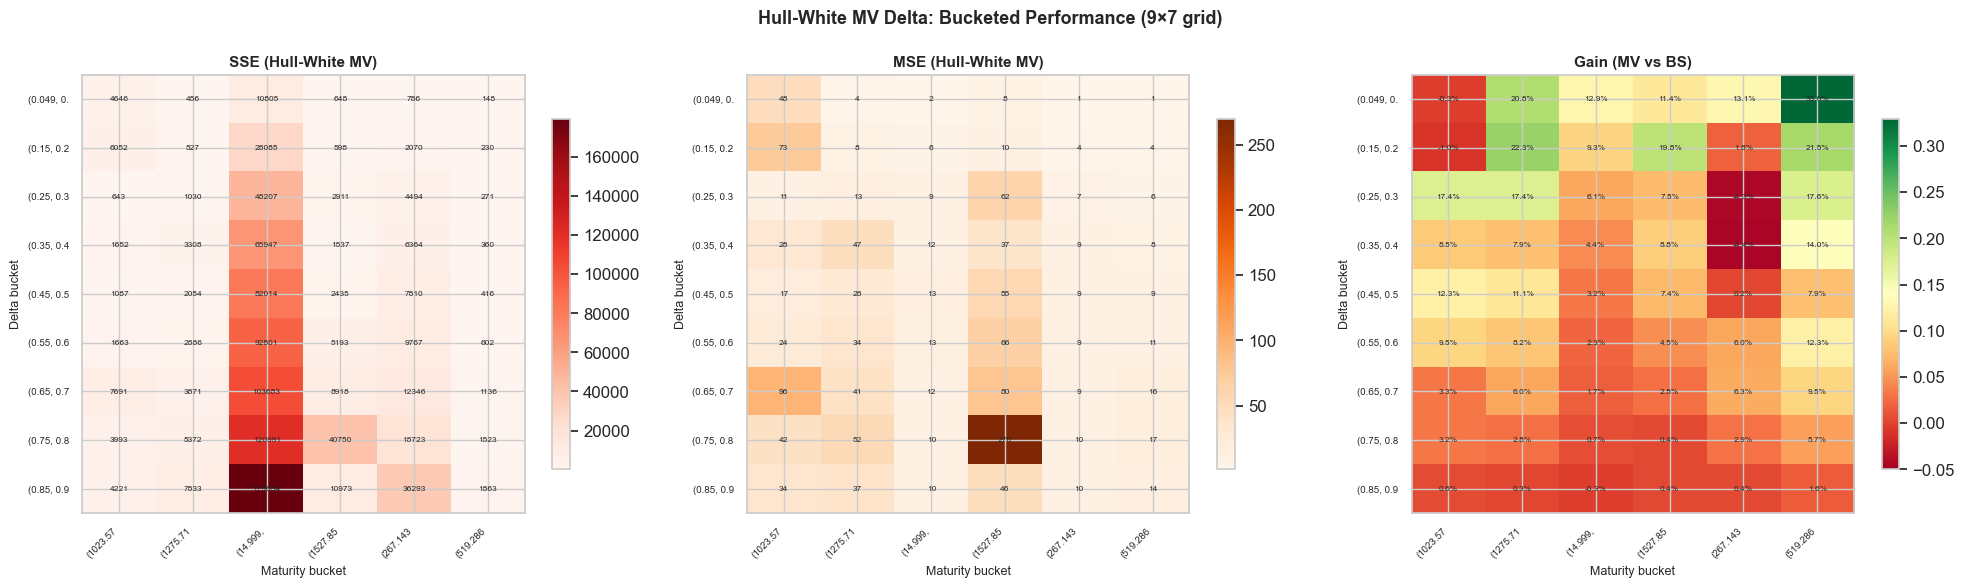

In [82]:
# Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, col, title, cmap in [
    (axes[0], "SSE_MV", "SSE (Hull-White MV)", "Reds"),
    (axes[1], "MSE_MV", "MSE (Hull-White MV)", "Oranges"),
    (axes[2], "Gain",   "Gain (MV vs BS)",     "RdYlGn"),
]:
    pivot = df_buckets.pivot_table(
        index="delta_bucket", columns="maturity_bucket",
        values=col, aggfunc="first"
    )
    vmin = None if col != "Gain" else -0.05
    vmax = None if col != "Gain" else pivot.max().max()
    im = ax.imshow(pivot.values, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([str(c)[:8] for c in pivot.columns], rotation=45, ha="right", fontsize=7)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([str(r)[:10] for r in pivot.index], fontsize=7)
    ax.set_xlabel("Maturity bucket", fontsize=9)
    ax.set_ylabel("Delta bucket", fontsize=9)
    ax.set_title(title, fontsize=11, fontweight="bold")
    # Annotate cells
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if np.isfinite(val):
                fmt = f"{val:.1%}" if col == "Gain" else f"{val:.0f}"
                ax.text(j, i, fmt, ha="center", va="center", fontsize=6)
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle("Hull-White MV Delta: Bucketed Performance (9×7 grid)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

#### Step 6: Standardized outputs for competitions
To participate in the ranking we must export ```HedgingScoreboard.csv``` containing:
    - total SSEs and MSE across the grid
    - bucketed results in tidy long format

**Submission:** Upload notebook, the two CSV files, and a short PDF report containing the required plots and short explanations.

In [89]:
# ══════════════════════════════════════════════════════════════
# Final HedgingScoreboard.csv Export
# Uses full-sample H&W coefficients estimated on all 18 days
# ══════════════════════════════════════════════════════════════

# ── Full-sample H&W coefficients (already computed) ──
print(f"Hull-White coefficients (full sample):")
print(f"  â = {a_hat:.6f},  b̂ = {b_hat:.6f},  ĉ = {c_hat:.6f}")

# ── MV delta (already in df_hw as delta_MV) ──
# Recompute residuals to be safe
eps_bs = df_hw["delta_Vt"] - df_hw["delta_BS"] * df_hw["delta_St"]
eps_mv = df_hw["delta_Vt"] - df_hw["delta_MV"] * df_hw["delta_St"]

SSE_BS_total = (eps_bs**2).sum()
SSE_MV_total = (eps_mv**2).sum()
MSE_BS_total = SSE_BS_total / len(df_hw)
MSE_MV_total = SSE_MV_total / len(df_hw)
Gain_total = 1 - SSE_MV_total / SSE_BS_total

print(f"\nTotal: SSE_BS={SSE_BS_total:,.2f}, SSE_MV={SSE_MV_total:,.2f}, "
      f"Gain={Gain_total:.4f} ({Gain_total*100:.2f}%)")

# ── 9×7 standardized bucketing ──
delta_bins = np.linspace(0.05, 0.95, 10)   # 9 moneyness buckets
dt_min = df_hw["Dt"].min()
dt_max = df_hw["Dt"].max()
dt_bins = np.linspace(dt_min, dt_max, 8)   # 7 maturity buckets

df_hw["delta_bucket"] = pd.cut(df_hw["delta_BS"], bins=delta_bins, include_lowest=True)
df_hw["maturity_bucket"] = pd.cut(df_hw["Dt"], bins=dt_bins, include_lowest=True)

# ── Bucketed SSE/MSE ──
records = []
for (db, mb), grp in df_hw.groupby(["delta_bucket", "maturity_bucket"], observed=True):
    if len(grp) == 0:
        continue
    e_bs = grp["delta_Vt"] - grp["delta_BS"] * grp["delta_St"]
    e_mv = grp["delta_Vt"] - grp["delta_MV"] * grp["delta_St"]
    sse_bs = (e_bs**2).sum()
    sse_mv = (e_mv**2).sum()
    records.append({
        "delta_bucket": str(db),
        "maturity_bucket": str(mb),
        "SSE_BS": sse_bs,
        "SSE_MV": sse_mv,
        "MSE_BS": sse_bs / len(grp),
        "MSE_MV": sse_mv / len(grp),
        "Gain": 1 - sse_mv / sse_bs if sse_bs > 0 else 0,
        "N": len(grp)
    })

df_buckets = pd.DataFrame(records)

# ── Assemble scoreboard: total row + bucketed rows ──
total_row = pd.DataFrame([{
    "delta_bucket": "ALL",
    "maturity_bucket": "ALL",
    "SSE_BS": SSE_BS_total,
    "SSE_MV": SSE_MV_total,
    "MSE_BS": MSE_BS_total,
    "MSE_MV": MSE_MV_total,
    "Gain": Gain_total,
    "N": len(df_hw)
}])

df_scoreboard = pd.concat([total_row, df_buckets], ignore_index=True)

# ── Export ──
df_scoreboard.to_csv("HedgingScoreboard.csv", index=False)

print(f"\nExported HedgingScoreboard.csv")
print(f"  Total rows: {len(df_scoreboard)} (1 total + {len(df_buckets)} buckets)")
print(f"\nFirst rows:")
print(df_scoreboard.head(5).to_string(index=False))
print(f"\n...last rows:")
print(df_scoreboard.tail(3).to_string(index=False))

Hull-White coefficients (full sample):
  â = -0.066110,  b̂ = -0.013965,  ĉ = 0.084968

Total: SSE_BS=994,700.65, SSE_MV=970,336.73, Gain=0.0245 (2.45%)

Exported HedgingScoreboard.csv
  Total rows: 55 (1 total + 54 buckets)

First rows:
 delta_bucket      maturity_bucket        SSE_BS        SSE_MV    MSE_BS    MSE_MV      Gain     N
          ALL                  ALL 994700.651099 970336.727734 11.324650 11.047267  0.024494 87835
(0.049, 0.15]    (14.999, 267.143]  12405.102264  10804.604800  2.303212  2.006054  0.129019  5386
(0.049, 0.15]   (267.143, 519.286]    903.951839    785.921204  1.367552  1.188988  0.130572   661
(0.049, 0.15]   (519.286, 771.429]    220.639795    147.873323  1.987746  1.332192  0.329798   111
(0.049, 0.15] (1023.571, 1275.714]   4631.357258   4646.173616 48.243305 48.397642 -0.003199    96

...last rows:
delta_bucket      maturity_bucket       SSE_BS       SSE_MV    MSE_BS    MSE_MV     Gain   N
(0.85, 0.95] (1023.571, 1275.714]  4247.115538  4221.466804 

#### Testing Performance
Train-test split to evaluate performance.


In [83]:
# ── Split by date ──
trading_days = sorted(df_hw["date"].unique())
n_days = len(trading_days)
split_idx = n_days * 2 // 3  # ~12 days train, ~6 test

train_dates = trading_days[:split_idx]
test_dates = trading_days[split_idx:]

df_train = df_hw[df_hw["date"].isin(train_dates)].copy()
df_test = df_hw[df_hw["date"].isin(test_dates)].copy()

print(f"Trading days: {n_days}")
print(f"Train: {len(train_dates)} days ({train_dates[0].date()} to {train_dates[-1].date()}), "
      f"{len(df_train):,} obs")
print(f"Test:  {len(test_dates)} days ({test_dates[0].date()} to {test_dates[-1].date()}), "
      f"{len(df_test):,} obs")

Trading days: 18
Train: 12 days (2023-02-01 to 2023-02-16), 58,153 obs
Test:  6 days (2023-02-17 to 2023-02-27), 29,682 obs


In [84]:
eps_train = df_train["delta_Vt"] - df_train["delta_BS"] * df_train["delta_St"]

scale_train = (df_train["vega"] * df_train["delta_St"]) / (
    df_train["St"] * np.sqrt(df_train["tau"])
)

X_train = np.column_stack([
    scale_train * 1,
    scale_train * df_train["delta_BS"],
    scale_train * df_train["delta_BS"]**2
])

mask_tr = np.isfinite(X_train).all(axis=1) & np.isfinite(eps_train)
coeffs_oos, _, _, _ = np.linalg.lstsq(X_train[mask_tr], eps_train.values[mask_tr], rcond=None)
a_oos, b_oos, c_oos = coeffs_oos

print(f"\nTrain coefficients: â={a_oos:.6f}, b̂={b_oos:.6f}, ĉ={c_oos:.6f}")



Train coefficients: â=-0.007579, b̂=-0.010834, ĉ=0.006791


In [85]:
# Apply frozen coefficients to test set
vega_corr_test = (df_test["vega"] / (df_test["St"] * np.sqrt(df_test["tau"]))) * (
    a_oos + b_oos * df_test["delta_BS"] + c_oos * df_test["delta_BS"]**2
)
df_test["delta_MV_oos"] = df_test["delta_BS"] + vega_corr_test

eps_bs_test = df_test["delta_Vt"] - df_test["delta_BS"] * df_test["delta_St"]
eps_mv_test = df_test["delta_Vt"] - df_test["delta_MV_oos"] * df_test["delta_St"]

SSE_BS_test = (eps_bs_test**2).sum()
SSE_MV_test = (eps_mv_test**2).sum()
Gain_oos = 1 - SSE_MV_test / SSE_BS_test

In [86]:
print(f"\n{'='*60}")
print(f"  Out-of-sample performance (test set)")
print(f"{'='*60}")
print(f"  SSE (vendor BS):             {SSE_BS_test:>14,.2f}")
print(f"  SSE (Hull-White MV):         {SSE_MV_test:>14,.2f}")
print(f"  Gain:                        {Gain_oos:>14.4f}  ({Gain_oos*100:.2f}%)")
print(f"{'='*60}")


  Out-of-sample performance (test set)
  SSE (vendor BS):                 385,594.63
  SSE (Hull-White MV):             377,144.77
  Gain:                                0.0219  (2.19%)


In [87]:
# Compare: in-sample vs out-of-sample
# In-sample gain on train set
vega_corr_tr = (df_train["vega"] / (df_train["St"] * np.sqrt(df_train["tau"]))) * (
    a_oos + b_oos * df_train["delta_BS"] + c_oos * df_train["delta_BS"]**2
)
eps_mv_tr = df_train["delta_Vt"] - (df_train["delta_BS"] + vega_corr_tr) * df_train["delta_St"]
Gain_is = 1 - (eps_mv_tr**2).sum() / (eps_train**2).sum()

print(f"\n  In-sample Gain (train):      {Gain_is:.4f}  ({Gain_is*100:.2f}%)")
print(f"  Out-of-sample Gain (test):   {Gain_oos:.4f}  ({Gain_oos*100:.2f}%)")
print(f"  Gain drop:                   {(Gain_is - Gain_oos)*100:.2f} pp")


  In-sample Gain (train):      0.0016  (0.16%)
  Out-of-sample Gain (test):   0.0219  (2.19%)
  Gain drop:                   -2.04 pp


In [90]:
print("Daily ΔS statistics:")
print(f"  Train: mean={df_train['delta_St'].mean():.2f}, "
      f"std={df_train['delta_St'].std():.2f}, "
      f"min={df_train['delta_St'].min():.2f}")
print(f"  Test:  mean={df_test['delta_St'].mean():.2f}, "
      f"std={df_test['delta_St'].std():.2f}, "
      f"min={df_test['delta_St'].min():.2f}")

#FIXME: This might or might not be problematic!

Daily ΔS statistics:
  Train: mean=-3.22, std=38.65, min=-57.19
  Test:  mean=-18.16, std=34.69, min=-81.75
